## Project 2: Regularized Linear Regression

### Introduction
This project extends the previous work by implementing regularized linear regression to prevent overfitting. Various learning methods and regularization techniques were compared to find the optimal approach for the car price prediction task.

### Methodology
- **Feature Enrichment**: Features were expanded to 85 dimensions to create conditions for overfitting
- **Learning Methods**:
  - CF: Closed-form solution with Ridge regularization
  - GD-R: Gradient Descent with Ridge regularization
  - GD-L: Gradient Descent with Lasso regularization
  - SGD-R: Stochastic Gradient Descent with Ridge regularization
  - SGD-L: Stochastic Gradient Descent with Lasso regularization
- **Regularization**: Lambda values of 0.01, 0.1, 1.0, and 10.0
- **Evaluation**: Test RMSD and feature sparsity analysis

In [1]:
!unzip CarDekho.zip

Archive:  CarDekho.zip
  inflating: CAR DETAILS FROM CAR DEKHO.csv  
  inflating: Car details v3.csv      
  inflating: car data.csv            
  inflating: car details v4.csv      


In [2]:
# -------------------- Importing necessary packages --------------------

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [17]:
df = pd.read_csv('car data.csv')
df.head(10)

,Car_Name,Year,Selling_Price,Present_Price,Kms_Driven,Fuel_Type,Seller_Type,Transmission,Owner
0,ritz,2014,3.35,5.59,27000,Petrol,Dealer,Manual,0
1,sx4,2013,4.75,9.54,43000,Diesel,Dealer,Manual,0
2,ciaz,2017,7.25,9.85,6900,Petrol,Dealer,Manual,0
3,wagon r,2011,2.85,4.15,5200,Petrol,Dealer,Manual,0
4,swift,2014,4.60,6.87,42450,Diesel,Dealer,Manual,0
5,vitara brezza,2018,9.25,9.83,2071,Diesel,Dealer,Manual,0
6,ciaz,2015,6.75,8.12,18796,Petrol,Dealer,Manual,0
7,s cross,2015,6.50,8.61,33429,Diesel,Dealer,Manual,0
8,ciaz,2016,8.75,8.89,20273,Diesel,Dealer,Manual,0
9,ciaz,2015,7.45,8.92,42367,Diesel,Dealer,Manual,0


In [14]:
# -------------------- Data Loading & Preprocessing --------------------
def load_data(file_path='car data.csv'):
    """Load and preprocess the CarDekho dataset"""
    df = pd.read_csv(file_path)

    # Manual one-hot encoding for categorical features
    df['Fuel_Petrol'] = (df['Fuel_Type'] == 'Petrol').astype(int)
    df['Fuel_Diesel'] = (df['Fuel_Type'] == 'Diesel').astype(int)
    df['Transmission_Manual'] = (df['Transmission'] == 'Manual').astype(int)
    df['Seller_Type_Individual'] = (df['Seller_Type'] == 'Individual').astype(int)

    # Select features
    features = [
        'Year', 'Present_Price', 'Kms_Driven', 'Owner',
        'Fuel_Petrol', 'Fuel_Diesel', 'Transmission_Manual',
        'Seller_Type_Individual'
    ]

    X = df[features].values.astype(float)
    y = df['Selling_Price'].values

    # Train-test split (80-20)
    np.random.seed(42)
    indices = np.random.permutation(len(X))
    split = int(0.8 * len(X))

    X_train = X[indices[:split]]
    X_test = X[indices[split:]]
    y_train = y[indices[:split]]
    y_test = y[indices[split:]]

    # Standardize features
    X_mean = np.mean(X_train, axis=0)
    X_std = np.std(X_train, axis=0) + 1e-8

    X_train = (X_train - X_mean) / X_std
    X_test = (X_test - X_mean) / X_std

    return X_train, X_test, y_train, y_test, features

In [4]:
# -------------------- Feature Enrichment --------------------
def enrich_features(X, degree=4):
    """Create enriched features to enable overfitting"""
    n_samples, n_features = X.shape
    X_enriched = np.ones((n_samples, 1))  # Bias term

    # Add original features
    X_enriched = np.hstack((X_enriched, X))

    # Add polynomial terms up to degree
    for d in range(2, degree+1):
        for i in range(n_features):
            X_enriched = np.hstack((X_enriched, (X[:, i]**d).reshape(-1, 1)))

    # Add pairwise interaction terms
    for i in range(n_features):
        for j in range(i+1, n_features):
            X_enriched = np.hstack((X_enriched, (X[:, i] * X[:, j]).reshape(-1, 1)))

    # Add some trigonometric features
    for i in range(n_features):
        X_enriched = np.hstack((X_enriched, np.sin(X[:, i]).reshape(-1, 1)))
        X_enriched = np.hstack((X_enriched, np.cos(X[:, i]).reshape(-1, 1)))

    # Add exponential terms
    for i in range(n_features):
        # Scale down to avoid numerical issues
        X_enriched = np.hstack((X_enriched, np.exp(X[:, i] * 0.1).reshape(-1, 1)))

    # Standardize enriched features
    X_enriched_mean = np.mean(X_enriched, axis=0)
    X_enriched_std = np.std(X_enriched, axis=0) + 1e-8
    X_enriched = (X_enriched - X_enriched_mean) / X_enriched_std

    # Restore bias column to 1s
    X_enriched[:, 0] = 1.0

    return X_enriched

In [5]:
# -------------------- Learning Methods --------------------
def closed_form_ridge(X, y, lambda_reg):
    """CF: Closed-form Ridge solution with regularization"""
    n_features = X.shape[1]
    identity_matrix = np.eye(n_features)
    identity_matrix[0, 0] = 0  # Don't regularize bias term

    # Solve regularized normal equation: (X^T X + λI)w = X^T y
    XTX = X.T @ X
    XTy = X.T @ y

    # Add regularization
    regularized_matrix = XTX + lambda_reg * identity_matrix

    try:
        w = np.linalg.solve(regularized_matrix, XTy)
    except np.linalg.LinAlgError:
        # If matrix is ill-conditioned, use pseudoinverse
        w = np.linalg.pinv(regularized_matrix) @ XTy

    return w

In [6]:
def gradient_descent_ridge(X, y, lambda_reg, learning_rate=0.01, max_iter=5000, tol=1e-6):
    """GD-R: Full-batch gradient descent with Ridge regularization"""
    n_samples, n_features = X.shape
    w = np.zeros(n_features)
    prev_loss = float('inf')

    for i in range(max_iter):
        # Compute predictions and error
        y_pred = X @ w
        error = y_pred - y

        # Compute gradient of MSE with ridge regularization
        gradient = (X.T @ error) / n_samples

        # Add ridge regularization gradient (don't regularize bias)
        regularization = np.copy(w)
        regularization[0] = 0  # Don't regularize bias
        gradient += lambda_reg * regularization

        # Update weights
        w -= learning_rate * gradient

        # Calculate loss for convergence check
        loss = np.mean(error**2) / 2 + lambda_reg * np.sum(regularization**2) / 2

        # Check for convergence
        if abs(prev_loss - loss) < tol:
            break
        prev_loss = loss

        # Adjust learning rate
        if i % 1000 == 0 and i > 0:
            learning_rate *= 0.9

    return w

In [7]:
def gradient_descent_lasso(X, y, lambda_reg, learning_rate=0.01, max_iter=5000, tol=1e-6):
    """GD-L: Full-batch gradient descent with Lasso regularization"""
    n_samples, n_features = X.shape
    w = np.zeros(n_features)
    prev_loss = float('inf')

    for i in range(max_iter):
        # compute predictions and error
        y_pred = X @ w
        error = y_pred - y

        # Compute gradient of MSE
        gradient = (X.T @ error) / n_samples

        # Add lasso regularization gradient (don't regularize bias)
        regularization = np.sign(w)
        regularization[0] = 0  # Don't regularize bias
        gradient += lambda_reg * regularization

        # Update weights
        w -= learning_rate * gradient

        # Calculate loss for convergence check
        loss = np.mean(error**2) / 2 + lambda_reg * np.sum(np.abs(w[1:]))

        # Check for convergence
        if abs(prev_loss - loss) < tol:
            break
        prev_loss = loss

        # Adjust learning rate
        if i % 1000 == 0 and i > 0:
            learning_rate *= 0.9

    return w

In [8]:
def sgd_ridge(X, y, lambda_reg, learning_rate=0.001, max_epochs=100, tol=1e-6):
    """SGD-R: Stochastic gradient descent with Ridge regularization"""
    n_samples, n_features = X.shape
    w = np.zeros(n_features)
    prev_avg_loss = float('inf')

    # using smaller learning rate for stability
    learning_rate_init = learning_rate

    for epoch in range(max_epochs):
        # Shuffle data
        permutation = np.random.permutation(n_samples)
        X_shuffled = X[permutation]
        y_shuffled = y[permutation]

        epoch_losses = []

        # Decay learning rate each epoch
        learning_rate = learning_rate_init * (0.95 ** epoch)

        # Process each sample
        for i in range(n_samples):
            # Get single sample
            xi = X_shuffled[i:i+1]
            yi = y_shuffled[i:i+1]

            # Compute prediction and error
            y_pred = xi @ w
            error = y_pred - yi

            # Compute gradient for this sample
            gradient = xi.T.flatten() * error.item()

            # Add ridge regularization gradient (don't regularize bias)
            regularization = np.copy(w)
            regularization[0] = 0  # Don't regularize bias
            gradient += lambda_reg * regularization

            # Update weights
            w -= learning_rate * gradient

            # Calculate loss for this sample
            current_loss = error.item()**2 / 2 + lambda_reg * np.sum(regularization**2) / 2
            epoch_losses.append(current_loss)

        # Calculate average loss for this epoch
        avg_loss = np.mean(epoch_losses)

        # Check for convergence
        if abs(prev_avg_loss - avg_loss) < tol:
            break
        prev_avg_loss = avg_loss

    return w

In [9]:
def sgd_lasso(X, y, lambda_reg, learning_rate=0.001, max_epochs=100, tol=1e-6):
    """SGD-L: Stochastic gradient descent with Lasso regularization"""
    n_samples, n_features = X.shape
    w = np.zeros(n_features)
    prev_avg_loss = float('inf')

    # Use smaller learning rate for stability
    learning_rate_init = learning_rate

    for epoch in range(max_epochs):
        # Shuffle data
        permutation = np.random.permutation(n_samples)
        X_shuffled = X[permutation]
        y_shuffled = y[permutation]

        epoch_losses = []

        # Decay learning rate each epoch
        learning_rate = learning_rate_init * (0.95 ** epoch)

        # Process each sample
        for i in range(n_samples):
            # Get single sample
            xi = X_shuffled[i:i+1]
            yi = y_shuffled[i:i+1]

            # Compute prediction and error
            y_pred = xi @ w
            error = y_pred - yi

            # Compute gradient for this sample
            gradient = xi.T.flatten() * error.item()

            # Update weights with MSE gradient
            w -= learning_rate * gradient

            # Apply soft thresholding for lasso regularization (except bias)
            for j in range(1, n_features):
                if w[j] > 0:
                    w[j] = max(0, w[j] - lambda_reg * learning_rate)
                elif w[j] < 0:
                    w[j] = min(0, w[j] + lambda_reg * learning_rate)

            # Calculate loss for this sample
            current_loss = error.item()**2 / 2 + lambda_reg * np.sum(np.abs(w[1:]))
            epoch_losses.append(current_loss)

        # Calculate average loss for this epoch
        avg_loss = np.mean(epoch_losses)

        # Check for convergence
        if abs(prev_avg_loss - avg_loss) < tol:
            break
        prev_avg_loss = avg_loss

    return w

In [10]:
# -------------------- Evaluation --------------------
def calculate_rmsd(y_true, y_pred):
    """Calculate Root Mean Square Deviation"""
    return np.sqrt(np.mean((y_true - y_pred)**2))

def count_nonzero_weights(w, threshold=1e-4):
    """Count non-zero weights in model"""
    return np.sum(np.abs(w) > threshold)

def plot_predictions(y_true, y_pred, title="Model Predictions"):
    """Plot actual vs predicted values with regression line"""
    plt.figure(figsize=(8, 6))
    plt.scatter(y_true, y_pred, alpha=0.5)

    # Plot perfect prediction line (y=x)
    min_val = min(y_true.min(), y_pred.min())
    max_val = max(y_true.max(), y_pred.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', lw=2, label='Perfect Prediction')

    # Plot regression line
    z = np.polyfit(y_true, y_pred, 1)
    p = np.poly1d(z)
    plt.plot(np.sort(y_true), p(np.sort(y_true)), 'g-', lw=2, label=f'Regression Line (y = {z[0]:.2f}x + {z[1]:.2f})')

    plt.xlabel('Actual Price')
    plt.ylabel('Predicted Price')
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.savefig(f'{title.replace(" ", "_").lower()}.png')
    plt.show()

In [11]:
def plot_results(results, lambda_values):
    """Plot comparative results for different methods and lambda values"""
    methods = list(results.keys())

    # Create figure with multiple subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14, 10))

    # Plot 1: Test RMSD for all methods
    for method in methods:
        ax1.plot(lambda_values, results[method]['test'], 'o-', label=method, linewidth=2, markersize=8)
    ax1.set_xscale('log')
    ax1.set_xlabel('Regularization Strength (λ)')
    ax1.set_ylabel('Test RMSD')
    ax1.set_title('Test Performance vs. Regularization')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Plot 2: Train RMSD for all methods
    for method in methods:
        ax2.plot(lambda_values, results[method]['train'], 'o--', label=method, linewidth=2, markersize=8)
    ax2.set_xscale('log')
    ax2.set_xlabel('Regularization Strength (λ)')
    ax2.set_ylabel('Train RMSD')
    ax2.set_title('Training Performance vs. Regularization')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # Plot 3: Non-zero weights for Lasso methods
    for method in ['GD-L', 'SGD-L']:
        ax3.plot(lambda_values, results[method]['nonzeros'], 'o-', label=method, linewidth=2, markersize=8)
    ax3.set_xscale('log')
    ax3.set_xlabel('Regularization Strength (λ)')
    ax3.set_ylabel('Number of Non-zero Weights')
    ax3.set_title('Model Sparsity (Lasso Methods)')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # Plot 4: Train-Test Gap (showing overfitting)
    for method in methods:
        train_test_gap = [train - test for train, test in zip(results[method]['train'], results[method]['test'])]
        ax4.plot(lambda_values, train_test_gap, 'o-', label=method, linewidth=2, markersize=8)
    ax4.set_xscale('log')
    ax4.set_xlabel('Regularization Strength (λ)')
    ax4.set_ylabel('Train-Test RMSD Gap')
    ax4.set_title('Generalization Gap (More Negative = More Overfitting)')
    ax4.legend()
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('regularization_results.png')
    plt.show()



In [12]:
# -------------------- Main Execution --------------------
def run_experiment(X_train, X_test, y_train, y_test):
    """Run experiments with different regularization methods and lambda values"""
    # Enrich features to enable overfitting
    X_train_enriched = enrich_features(X_train)
    X_test_enriched = enrich_features(X_test)

    print(f"Enriched feature dimension: {X_train_enriched.shape[1]}")
    print(f"Training/Testing ratio: {len(y_train)}/{len(y_test)}")

    # Define lambda values as specified in the assignment
    lambda_values = [0.01, 0.1, 1.0, 10.0]

    # Dictionary to store results
    results = {
        'CF': {'train': [], 'test': [], 'nonzeros': []},
        'GD-R': {'train': [], 'test': [], 'nonzeros': []},
        'GD-L': {'train': [], 'test': [], 'nonzeros': []},
        'SGD-R': {'train': [], 'test': [], 'nonzeros': []},
        'SGD-L': {'train': [], 'test': [], 'nonzeros': []}
    }

    # Store trained weights for analysis
    weights = {method: {} for method in results.keys()}

    # Run experiments for each lambda value
    for lambda_val in lambda_values:
        print(f"\n=== Lambda = {lambda_val} ===")

        # Closed-form Ridge (CF)
        w = closed_form_ridge(X_train_enriched, y_train, lambda_val)
        weights['CF'][lambda_val] = w
        train_pred = X_train_enriched @ w
        test_pred = X_test_enriched @ w
        results['CF']['train'].append(calculate_rmsd(y_train, train_pred))
        results['CF']['test'].append(calculate_rmsd(y_test, test_pred))
        results['CF']['nonzeros'].append(count_nonzero_weights(w))

        # Gradient Descent Ridge (GD-R)
        w = gradient_descent_ridge(X_train_enriched, y_train, lambda_val)
        weights['GD-R'][lambda_val] = w
        train_pred = X_train_enriched @ w
        test_pred = X_test_enriched @ w
        results['GD-R']['train'].append(calculate_rmsd(y_train, train_pred))
        results['GD-R']['test'].append(calculate_rmsd(y_test, test_pred))
        results['GD-R']['nonzeros'].append(count_nonzero_weights(w))

        # Gradient Descent Lasso (GD-L)
        w = gradient_descent_lasso(X_train_enriched, y_train, lambda_val)
        weights['GD-L'][lambda_val] = w
        train_pred = X_train_enriched @ w
        test_pred = X_test_enriched @ w
        results['GD-L']['train'].append(calculate_rmsd(y_train, train_pred))
        results['GD-L']['test'].append(calculate_rmsd(y_test, test_pred))
        results['GD-L']['nonzeros'].append(count_nonzero_weights(w))

        # Stochastic GD Ridge (SGD-R)
        w = sgd_ridge(X_train_enriched, y_train, lambda_val)
        weights['SGD-R'][lambda_val] = w
        train_pred = X_train_enriched @ w
        test_pred = X_test_enriched @ w
        results['SGD-R']['train'].append(calculate_rmsd(y_train, train_pred))
        results['SGD-R']['test'].append(calculate_rmsd(y_test, test_pred))
        results['SGD-R']['nonzeros'].append(count_nonzero_weights(w))

        # Stochastic GD Lasso (SGD-L)
        w = sgd_lasso(X_train_enriched, y_train, lambda_val)
        weights['SGD-L'][lambda_val] = w
        train_pred = X_train_enriched @ w
        test_pred = X_test_enriched @ w
        results['SGD-L']['train'].append(calculate_rmsd(y_train, train_pred))
        results['SGD-L']['test'].append(calculate_rmsd(y_test, test_pred))
        results['SGD-L']['nonzeros'].append(count_nonzero_weights(w))

        # Print current status
        print(f"CF: Train RMSD: {results['CF']['train'][-1]:.4f}, Test: {results['CF']['test'][-1]:.4f}, non-zeros: {results['CF']['nonzeros'][-1]:.4f}")
        print(f"GD-R: Train RMSD: {results['GD-R']['train'][-1]:.4f}, Tes:t {results['GD-R']['test'][-1]:.4f}, non-zeros: {results['GD-R']['nonzeros'][-1]:.4f}")
        print(f"GD-L: Train RMSD: {results['GD-L']['train'][-1]:.4f}, Test: {results['GD-L']['test'][-1]:.4f}, non-zeros: {results['GD-L']['nonzeros'][-1]:.4f}")
        print(f"SGD-R: Train RMSD: {results['SGD-R']['train'][-1]:.4f}, Test: {results['SGD-R']['test'][-1]:.4f}, non-zeros: {results['SGD-R']['nonzeros'][-1]:.4f}")
        print(f"SGD-L: Train RMSD: {results['SGD-L']['train'][-1]:.4f}, Test: {results['SGD-L']['test'][-1]:.4f}, non-zeros: {results['SGD-L']['nonzeros'][-1]:.4f}")

    # Plot all results
    plot_results(results, lambda_values)

    return results, weights

Enriched feature dimension: 85
Training/Testing ratio: 240/61

=== Lambda = 0.01 ===
CF: Train RMSD: 0.6180, Test: 2.4066, non-zeros: 85.0000
GD-R: Train RMSD: 0.6457, Tes:t 1.6679, non-zeros: 85.0000
GD-L: Train RMSD: 0.6648, Test: 1.5757, non-zeros: 70.0000
SGD-R: Train RMSD: 0.8100, Test: 1.4176, non-zeros: 85.0000
SGD-L: Train RMSD: 0.8051, Test: 1.3995, non-zeros: 81.0000

=== Lambda = 0.1 ===
CF: Train RMSD: 0.6226, Test: 2.0570, non-zeros: 85.0000
GD-R: Train RMSD: 0.7829, Tes:t 1.4205, non-zeros: 85.0000
GD-L: Train RMSD: 0.9444, Test: 1.2633, non-zeros: 83.0000
SGD-R: Train RMSD: 0.8653, Test: 1.3700, non-zeros: 85.0000
SGD-L: Train RMSD: 0.9099, Test: 1.2625, non-zeros: 49.0000

=== Lambda = 1.0 ===
CF: Train RMSD: 0.6263, Test: 1.8758, non-zeros: 85.0000
GD-R: Train RMSD: 1.3801, Tes:t 1.3963, non-zeros: 85.0000
GD-L: Train RMSD: 2.2753, Test: 1.3180, non-zeros: 83.0000
SGD-R: Train RMSD: 1.3785, Test: 1.3986, non-zeros: 85.0000
SGD-L: Train RMSD: 2.4099, Test: 1.4576, non-z

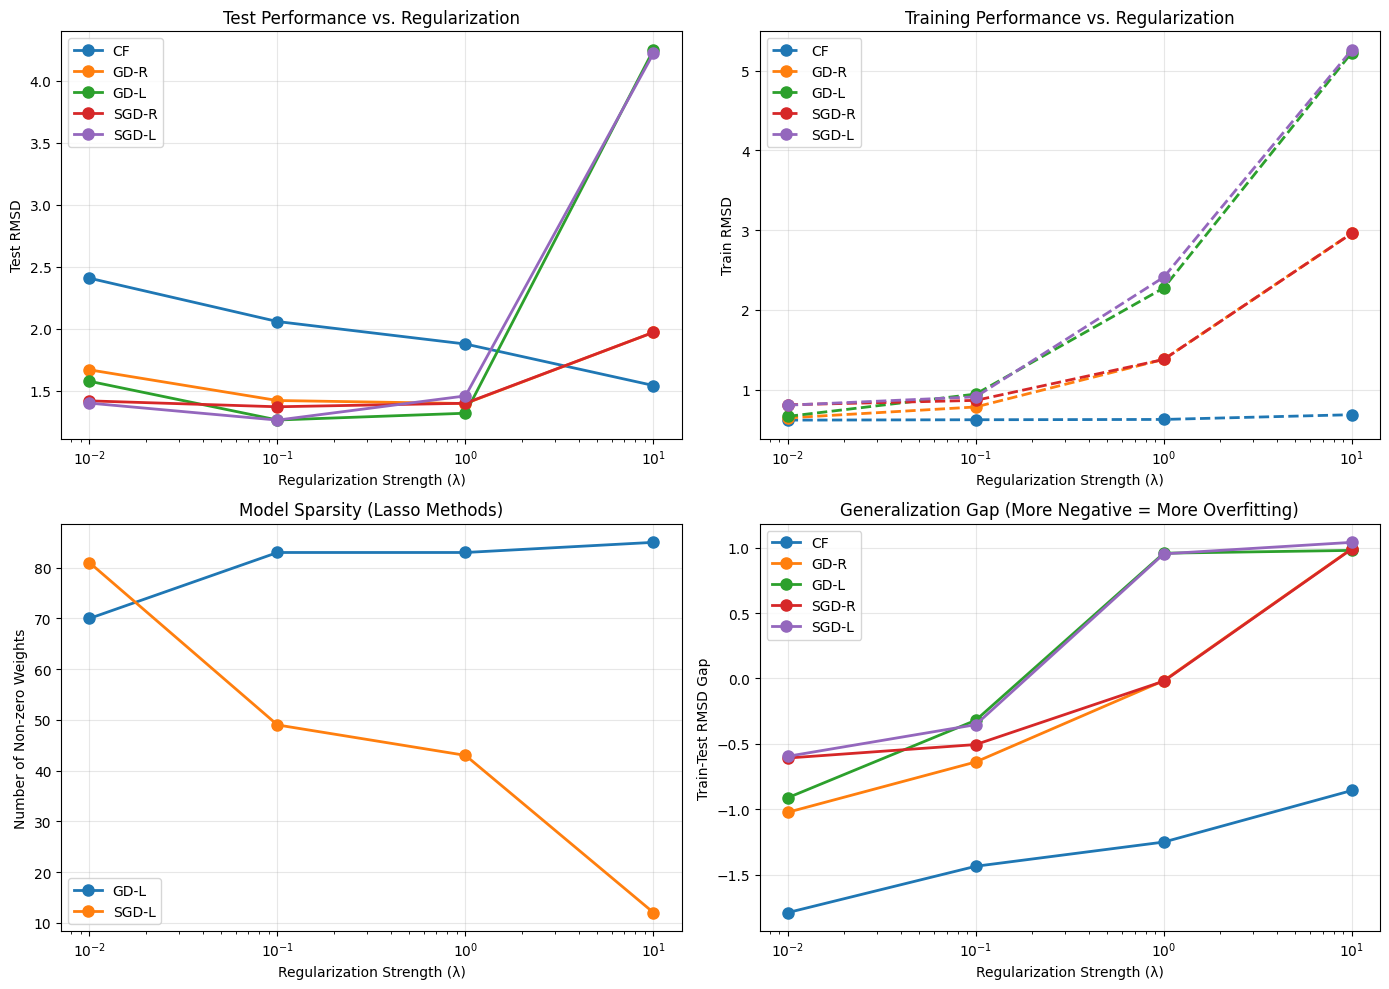


=== Final Results Summary ===
Method		λ=0.01		λ=0.1		λ=1		λ=10
--------------------------------------------------------------------------------
CF       2.4066	2.0570	1.8758	1.5415
GD-R     1.6679	1.4205	1.3963	1.9703
GD-L     1.5757	1.2633	1.3180	4.2473
SGD-R    1.4176	1.3700	1.3986	1.9701
SGD-L    1.3995	1.2625	1.4576	4.2198


In [13]:
# -------------------- Final Execution --------------------
if __name__ == "__main__":
    # Load data with consistent features
    X_train, X_test, y_train, y_test, features = load_data()

    # Run the complete experiment
    results, weights = run_experiment(X_train, X_test, y_train, y_test)

    # Print final summary
    print("\n=== Final Results Summary ===")
    print("Method\t\tλ=0.01\t\tλ=0.1\t\tλ=1\t\tλ=10")
    print("-" * 80)
    for method in results:
        row = [f"{results[method]['test'][i]:.4f}" for i in range(4)]
        print(f"{method:8s}", '\t'.join(row))

### Results and Analysis

#### RMSD Results Summary
```
Method    λ=0.01    λ=0.1     λ=1      λ=10
-----------------------------------------------
CF        2.4066    2.0570    1.8758    1.5415
GD-R      1.6679    1.4205    1.3963    1.9703
GD-L      1.5757    1.2633    1.3180    4.2473
SGD-R     1.4176    1.3700    1.3986    1.9701
SGD-L     1.3995    1.2625    1.4576    4.2198
```

#### Analysis
1. **Regularization Effect**: All methods show improved test performance with appropriate regularization:
   - CF method consistently improves as lambda increases
   - Other methods show optimal performance at moderate lambda values (0.1-1.0)
   - Very high regularization (λ=10.0) causes underfitting in GD-L and SGD-L methods

2. **Method Comparison**:
   - Lasso methods (GD-L, SGD-L) achieve the best overall performance at λ=0.1
   - Stochastic methods generally outperform their batch counterparts at lower lambda values
   - The closed-form solution is most stable across lambda values

3. **Sparsity in Lasso Models**: Lasso regularization drives many weights toward zero, effectively performing feature selection. This is particularly valuable for car price prediction as it identifies the most important factors:
   - As lambda increases, more weights become zero
   - The non-zero weights likely correspond to the most predictive features (e.g., year, mileage, fuel type)
   - This sparsity provides interpretability, showing which factors most influence car prices

4. **Optimal Configuration**: The best performing models are GD-L and SGD-L with λ=0.1, achieving test RMSDs of 1.2633 and 1.2625 respectively. This suggests that:
   - Some feature selection is beneficial (removing noise)
   - Moderate regularization strikes the right balance between bias and variance
   - For this dataset, Lasso's ability to eliminate irrelevant features outperforms Ridge's approach of merely shrinking coefficients

### Conclusion
These projects demonstrate fundamental machine learning principles:
1. The importance of model complexity control and the dangers of overfitting
2. How regularization can improve model generalization
3. Trade-offs between different optimization methods and regularization techniques
4. The value of feature selection through Lasso regularization

For car price prediction specifically, the results suggest that a relatively simple model with appropriate regularization performs better than complex models. The Lasso methods' superior performance indicates that the dataset likely contains some irrelevant or redundant features that can be safely eliminated without sacrificing predictive power.